# In-Hospital Mortality
First of all what do we mean by "In-Hospital Mortality"? In-Hospital Mortality refers to a death occurred during the hospital stay.

## 1. Problem Statement

**The goal is to create a model that predicts if a patient will incur in death during its hospital stay.**

## 2. Type of model used for prediction
"In-Hospital Mortality" is a categorical attribute (YES,NO), so normally a classification model has to be used, but in this case we have a binary classifier so we could also treat the two possible output categories as numeric (YES=1, NO=0) and use a **regression model**. 

## 3. Metrics used for validation
For validation we use the Confusion Matrix which, as the name suggests gives us a matrix as output and describes the complete performance of the model.

<img src="images/confusionMatrix.png" alt="confusionMatrix">

There are 4 important terms in this performance:
- True Positives (TP): The cases in which we predicted YES and the actual output was also YES.
- True Negatives (TN): The cases in which we predicted NO and the actual output was NO.
- False Positives (FP): The cases in which we predicted YES and the actual output was NO.
- False Negatives (FN): The cases in which we predicted NO and the actual output was YES.

Accuracy for the matrix can be calculated by taking average of the values lying across the "main diagonal". 

<img src="images/accuracy.png" alt="accuracy">

Accuracy means how well the models predict all of the labels correctly. Higher accuracy means better performance, but using just the acuracy could be misleading.

So we use also other metrics like:

- **Precision**: It describes how well the model can predict the labels correctly.
<img src="images/precision.png" alt="precision">
- **Recall**: It describes how the model can retrieve all of the labels correctly.
<img src="images/recall.png" alt="recall">
- **F1 score**: It is the proportion between the multiplication of precision and recall divided by the addition of precision and recall then weighted by 2. This metric combines precision and recall. If the value gets larger, the better model is.
<img src="images/f1score.png" alt="F1score">

In [136]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

We start importing our baseline dataset extracted selecting only the necessary tables from MIMIC dataset.

In [137]:
# Import baseline dataset constructed in data extraction and preparation phase
admits_patients_diag = pd.read_csv('admits_patients_diag.csv')

#convert dates
admits_patients_diag.admittime = pd.to_datetime(admits_patients_diag.admittime)
admits_patients_diag.dischtime = pd.to_datetime(admits_patients_diag.dischtime)
admits_patients_diag.deathtime = pd.to_datetime(admits_patients_diag.deathtime)

admits_patients_diag.head()

,Unnamed: 0,subject_id,hadm_id,admittime,dischtime,deathtime,admission_type,insurance,ethnicity,died_at_the_hospital,...,injury,mental,misc,muscular,neoplasms,nervous,pregnancy,prenatal,respiratory,skin
0,0,14679932,21038362,2139-09-26 14:16:00,2139-09-28 11:30:00,NaT,ELECTIVE,Other,OTHER/UNKNOWN,0,...,2,0,0,0,0,0,0,0,0,0
1,1,15585972,24941086,2123-10-07 23:56:00,2123-10-12 11:22:00,NaT,ELECTIVE,Other,WHITE,0,...,2,0,0,0,0,0,0,0,0,0
2,2,15078341,23272159,2122-08-28 08:48:00,2122-08-30 12:32:00,NaT,ELECTIVE,Other,BLACK/AFRICAN AMERICAN,0,...,3,0,0,0,0,0,0,0,0,0
3,3,17301855,29732723,2140-06-06 14:23:00,2140-06-08 14:25:00,NaT,ELECTIVE,Other,WHITE,0,...,2,0,0,0,0,0,0,1,0,0
4,4,17991012,24298836,2181-07-10 20:28:00,2181-07-12 15:49:00,NaT,ELECTIVE,Other,WHITE,0,...,2,0,0,0,0,0,0,0,0,0


In [138]:
admits_patients_diag.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 335378 entries, 0 to 335377
Data columns (total 30 columns):
 #   Column                Non-Null Count   Dtype         
---  ------                --------------   -----         
 0   Unnamed: 0            335378 non-null  int64         
 1   subject_id            335378 non-null  int64         
 2   hadm_id               335378 non-null  int64         
 3   admittime             335378 non-null  datetime64[ns]
 4   dischtime             335378 non-null  datetime64[ns]
 5   deathtime             5670 non-null    datetime64[ns]
 6   admission_type        335378 non-null  object        
 7   insurance             335378 non-null  object        
 8   ethnicity             335378 non-null  object        
 9   died_at_the_hospital  335378 non-null  int64         
 10  gender                335378 non-null  object        
 11  anchor_age            335378 non-null  int64         
 12  dod                   24651 non-null   object        
 13 

In [139]:
# Create LOS attribute converting timedelta type into float 'days', 86400 seconds in a day
admits_patients_diag['los'] = (admits_patients_diag['dischtime'] - admits_patients_diag['admittime']).dt.total_seconds()/86400

# Verify LOS computation
admits_patients_diag[['admittime', 'dischtime', 'los']].head()

,admittime,dischtime,los
0,2139-09-26 14:16:00,2139-09-28 11:30:00,1.884722
1,2123-10-07 23:56:00,2123-10-12 11:22:00,4.476389
2,2122-08-28 08:48:00,2122-08-30 12:32:00,2.155556
3,2140-06-06 14:23:00,2140-06-08 14:25:00,2.001389
4,2181-07-10 20:28:00,2181-07-12 15:49:00,1.806250


We have computed the length of stay fo each admission because there are some LOS less than 0 (negative), they could refer to a patients died before the admission do this kind of entries have to be dropped.

In [140]:
# Remove LOS with negative number
admits_patients_diag = admits_patients_diag[admits_patients_diag['los'] > 0]
admits_patients_diag.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 335257 entries, 0 to 335377
Data columns (total 31 columns):
 #   Column                Non-Null Count   Dtype         
---  ------                --------------   -----         
 0   Unnamed: 0            335257 non-null  int64         
 1   subject_id            335257 non-null  int64         
 2   hadm_id               335257 non-null  int64         
 3   admittime             335257 non-null  datetime64[ns]
 4   dischtime             335257 non-null  datetime64[ns]
 5   deathtime             5605 non-null    datetime64[ns]
 6   admission_type        335257 non-null  object        
 7   insurance             335257 non-null  object        
 8   ethnicity             335257 non-null  object        
 9   died_at_the_hospital  335257 non-null  int64         
 10  gender                335257 non-null  object        
 11  anchor_age            335257 non-null  int64         
 12  dod                   24581 non-null   object        
 13 

In [141]:
admits_patients_diag.died_at_the_hospital.value_counts()

0    329652
1      5605
Name: died_at_the_hospital, dtype: int64

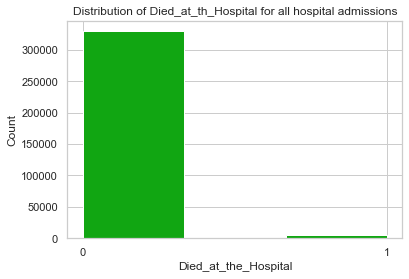

In [142]:
# Plot LOS Distribution
plt.hist(admits_patients_diag['died_at_the_hospital'], bins=3, color = '#11a612')
plt.title('Distribution of Died_at_th_Hospital for all hospital admissions')
plt.ylabel('Count')
plt.xlabel('Died_at_the_Hospital')
plt.xticks(range(0,2))
plt.show();

Died_at_the_Hospital = 1 means that the patients is died during the hospital stay. As we can see, luckily we have a small number of death compared to survivors.

In [143]:
print('Number of positive samples:', (admits_patients_diag.died_at_the_hospital == 1).sum()) # died at hospital
print('Number of negative samples:',  (admits_patients_diag.died_at_the_hospital == 0).sum()) # not died at hospital
print('Total samples:', len(admits_patients_diag))

Number of positive samples: 5605
Number of negative samples: 329652
Total samples: 335257


### Died_at_the_Hospital VS Ethnicity

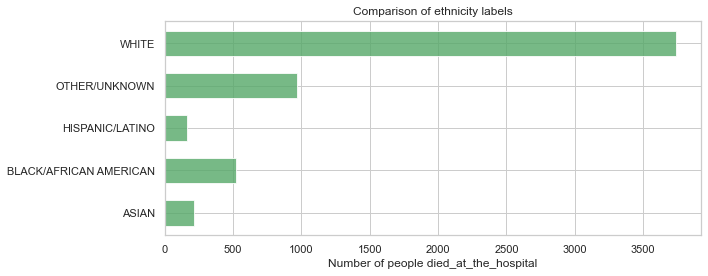

In [144]:
# Re-usable plotting function
def plot_los_groupby(variable, size=(7,4)):
    results = admits_patients_diag[[variable, 'died_at_the_hospital']].groupby(variable).sum().reset_index()
    values = list(results['died_at_the_hospital'].values)
    labels = list(results[variable].values)

    fig, ax = plt.subplots(figsize=size)
    ind = range(len(results))
    ax.barh(ind, values, align='center', height=0.6, color = '#55a868', alpha=0.8)
    ax.set_yticks(ind)
    ax.set_yticklabels(labels)
    ax.set_xlabel('Number of people died_at_the_hospital')
    ax.tick_params(left=False, top=False, right=False) 
    ax.set_title('Comparison of {} labels'.format(variable))
    plt.tight_layout()
    plt.show();

# Look at median LOS for groups ETHNICITY
plot_los_groupby('ethnicity', size=(10,4))

We can notice that Asian and Hispanic/latino people usually do not incur in death during their hospital stays.

### Died_at_the_Hospital VS Admission_Type

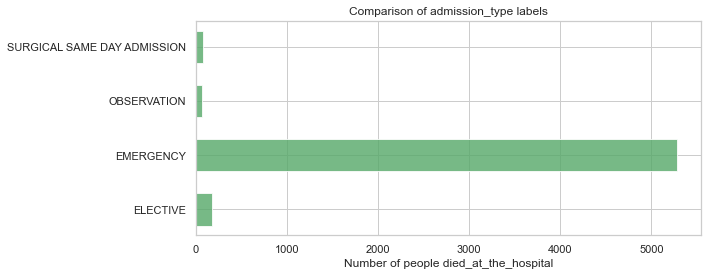

In [145]:
plot_los_groupby('admission_type', size=(10,4))

As we expect the biggest number of death is for patients admitted with emergency.

### Died_at_the_Hospital VS Age

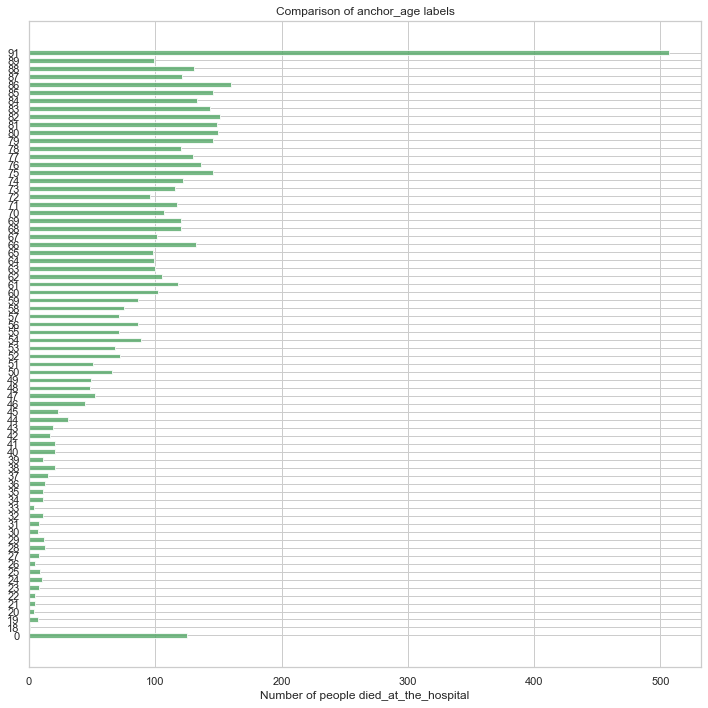

In [146]:
plot_los_groupby('anchor_age', size=(10,10))

Because of the discrete-like distribution of data on the extremes of age (0 and >89), it could be useful to convert all ages into the categories of **newborn, young adult, middle adult, and senior** for use in the prediction model.

In [147]:
age_ranges = [(0, 13), (14, 36), (37, 56), (57, 100)]
for num, cat_range in enumerate(age_ranges):
    admits_patients_diag['anchor_age'] = np.where(admits_patients_diag['anchor_age'].between(cat_range[0],cat_range[1]), num, admits_patients_diag['anchor_age'])

age_dict = {0: 'NEWBORN', 1: 'YOUNG_ADULT', 2: 'MIDDLE_ADULT', 3: 'SENIOR'}
admits_patients_diag['anchor_age'] = admits_patients_diag['anchor_age'].replace(age_dict)
admits_patients_diag.anchor_age.value_counts()

SENIOR          155448
MIDDLE_ADULT     88480
YOUNG_ADULT      52875
NEWBORN          38454
Name: anchor_age, dtype: int64

Now, let's analyze the diagnosis in correlation to our target LOS.

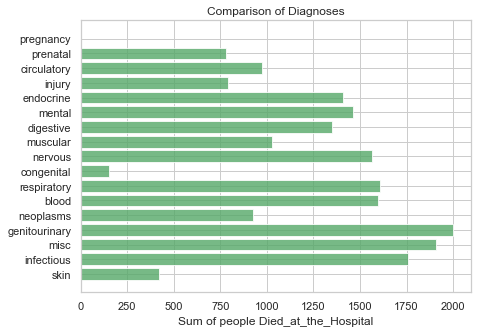

In [148]:
import seaborn as sns

# Look at the median LOS by diagnosis category
diag_cat_list = ['skin', 'infectious',  'misc', 'genitourinary', 'neoplasms', 'blood', 'respiratory', 
                  'congenital','nervous', 'muscular', 'digestive', 'mental', 'endocrine', 'injury',
                 'circulatory', 'prenatal',  'pregnancy']

results = []
for variable in diag_cat_list:
    results.append(admits_patients_diag[[variable, 'died_at_the_hospital']].groupby(variable).sum().reset_index().values[1][1])


sns.set(style="whitegrid")
fig, ax = plt.subplots(figsize=(7,5))
ind = range(len(results))
ax.barh(ind, results, color = '#55a868', alpha=0.8)
ax.set_yticks(ind)
ax.set_yticklabels(diag_cat_list)
ax.set_xlabel('Sum of people Died_at_the_Hospital')
ax.tick_params(left=False, right=False, top=False) 
ax.set_title('Comparison of Diagnoses'.format(variable))
plt.show();

We can have interesting insights from this plot: 
- the biggest number of deaths in hospital is for people diagnosed in the category **genitourinary**
- the lowest number of deaths in hospital (0 in the subset considered) is for people in **pregnancy**

### ICUSTAYS table data extraction

The data in the ICUSTAYS table could be useful because indicates if a patient during an admission was in an ICU (Intensive Care Unit). This of course could be a factor that could determine the death of the patient at the hospital.

In [149]:
mimic4_path = '../../mimic-iv-1.0/'

# read icustays table
def read_icustays_table(mimic4_path):
    icustays = pd.read_csv(mimic4_path + 'icu/icustays.csv')
    return icustays

icustays = read_icustays_table(mimic4_path)
icustays.head()

,subject_id,hadm_id,stay_id,first_careunit,last_careunit,intime,outtime,los
0,17867402,24528534,31793211,Trauma SICU (TSICU),Trauma SICU (TSICU),2154-03-03 04:11:00,2154-03-04 18:16:56,1.587454
1,14435996,28960964,31983544,Trauma SICU (TSICU),Trauma SICU (TSICU),2150-06-19 17:57:00,2150-06-22 18:33:54,3.025625
2,17609946,27385897,33183475,Trauma SICU (TSICU),Trauma SICU (TSICU),2138-02-05 18:54:00,2138-02-15 12:42:05,9.741725
3,18966770,23483021,34131444,Trauma SICU (TSICU),Trauma SICU (TSICU),2123-10-25 10:35:00,2123-10-25 18:59:47,0.350544
4,12776735,20817525,34547665,Neuro Stepdown,Neuro Stepdown,2200-07-12 00:33:00,2200-07-13 16:44:40,1.674769


In [150]:
icustays['category'] = icustays['first_careunit']
icu_list = icustays.groupby('hadm_id')['category'].apply(list).reset_index()
icu_list.head()

,hadm_id,category
0,20000094,[Coronary Care Unit (CCU)]
1,20000147,[Coronary Care Unit (CCU)]
2,20000351,[Medical/Surgical Intensive Care Unit (MICU/SI...
3,20000397,[Coronary Care Unit (CCU)]
4,20000808,"[Surgical Intensive Care Unit (SICU), Surgical..."


In [151]:
icustays['first_careunit'].value_counts()

Medical Intensive Care Unit (MICU)                  16729
Medical/Surgical Intensive Care Unit (MICU/SICU)    13421
Cardiac Vascular Intensive Care Unit (CVICU)        12169
Surgical Intensive Care Unit (SICU)                 11765
Trauma SICU (TSICU)                                  9165
Coronary Care Unit (CCU)                             8746
Neuro Surgical Intensive Care Unit (Neuro SICU)      1851
Neuro Intermediate                                   1823
Neuro Stepdown                                        871
Name: first_careunit, dtype: int64

In [152]:
# Create admission-ICU matrix
icu_item = pd.get_dummies(icu_list['category'].apply(pd.Series).stack()).sum(level=0)
icu_item[icu_item >= 1] = 1
icu_item = icu_item.join(icu_list['hadm_id'], how="outer")
icu_item.head()

,Cardiac Vascular Intensive Care Unit (CVICU),Coronary Care Unit (CCU),Medical Intensive Care Unit (MICU),Medical/Surgical Intensive Care Unit (MICU/SICU),Neuro Intermediate,Neuro Stepdown,Neuro Surgical Intensive Care Unit (Neuro SICU),Surgical Intensive Care Unit (SICU),Trauma SICU (TSICU),hadm_id
0,0,1,0,0,0,0,0,0,0,20000094
1,0,1,0,0,0,0,0,0,0,20000147
2,0,0,0,1,0,0,0,0,0,20000351
3,0,1,0,0,0,0,0,0,0,20000397
4,0,0,0,0,0,0,0,1,0,20000808


In [153]:
# Merge ICU data with main dataFrame
final_df = admits_patients_diag.merge(icu_item, how='outer', on='hadm_id')
final_df.head()

,Unnamed: 0,subject_id,hadm_id,admittime,dischtime,deathtime,admission_type,insurance,ethnicity,died_at_the_hospital,...,los,Cardiac Vascular Intensive Care Unit (CVICU),Coronary Care Unit (CCU),Medical Intensive Care Unit (MICU),Medical/Surgical Intensive Care Unit (MICU/SICU),Neuro Intermediate,Neuro Stepdown,Neuro Surgical Intensive Care Unit (Neuro SICU),Surgical Intensive Care Unit (SICU),Trauma SICU (TSICU)
0,0.0,14679932.0,21038362,2139-09-26 14:16:00,2139-09-28 11:30:00,NaT,ELECTIVE,Other,OTHER/UNKNOWN,0.0,...,1.884722,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1.0,15585972.0,24941086,2123-10-07 23:56:00,2123-10-12 11:22:00,NaT,ELECTIVE,Other,WHITE,0.0,...,4.476389,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2.0,15078341.0,23272159,2122-08-28 08:48:00,2122-08-30 12:32:00,NaT,ELECTIVE,Other,BLACK/AFRICAN AMERICAN,0.0,...,2.155556,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,3.0,17301855.0,29732723,2140-06-06 14:23:00,2140-06-08 14:25:00,NaT,ELECTIVE,Other,WHITE,0.0,...,2.001389,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,4.0,17991012.0,24298836,2181-07-10 20:28:00,2181-07-12 15:49:00,NaT,ELECTIVE,Other,WHITE,0.0,...,1.806250,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [154]:
# Replace NaNs with 0
final_df['Cardiac Vascular Intensive Care Unit (CVICU)'].fillna(value=0, inplace=True)
final_df['Coronary Care Unit (CCU)'].fillna(value=0, inplace=True)
final_df['Medical Intensive Care Unit (MICU)'].fillna(value=0, inplace=True)
final_df['Medical/Surgical Intensive Care Unit (MICU/SICU)'].fillna(value=0, inplace=True)
final_df['Neuro Intermediate'].fillna(value=0, inplace=True)
final_df['Neuro Stepdown'].fillna(value=0, inplace=True)
final_df['Neuro Surgical Intensive Care Unit (Neuro SICU)'].fillna(value=0, inplace=True)
final_df['Surgical Intensive Care Unit (SICU)'].fillna(value=0, inplace=True)
final_df['Trauma SICU (TSICU)'].fillna(value=0, inplace=True)

In [155]:
final_df.head()

,Unnamed: 0,subject_id,hadm_id,admittime,dischtime,deathtime,admission_type,insurance,ethnicity,died_at_the_hospital,...,los,Cardiac Vascular Intensive Care Unit (CVICU),Coronary Care Unit (CCU),Medical Intensive Care Unit (MICU),Medical/Surgical Intensive Care Unit (MICU/SICU),Neuro Intermediate,Neuro Stepdown,Neuro Surgical Intensive Care Unit (Neuro SICU),Surgical Intensive Care Unit (SICU),Trauma SICU (TSICU)
0,0.0,14679932.0,21038362,2139-09-26 14:16:00,2139-09-28 11:30:00,NaT,ELECTIVE,Other,OTHER/UNKNOWN,0.0,...,1.884722,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1.0,15585972.0,24941086,2123-10-07 23:56:00,2123-10-12 11:22:00,NaT,ELECTIVE,Other,WHITE,0.0,...,4.476389,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2.0,15078341.0,23272159,2122-08-28 08:48:00,2122-08-30 12:32:00,NaT,ELECTIVE,Other,BLACK/AFRICAN AMERICAN,0.0,...,2.155556,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,3.0,17301855.0,29732723,2140-06-06 14:23:00,2140-06-08 14:25:00,NaT,ELECTIVE,Other,WHITE,0.0,...,2.001389,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,4.0,17991012.0,24298836,2181-07-10 20:28:00,2181-07-12 15:49:00,NaT,ELECTIVE,Other,WHITE,0.0,...,1.806250,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## 5.Data Cleaning

In [156]:
final_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 362995 entries, 0 to 362994
Data columns (total 40 columns):
 #   Column                                            Non-Null Count   Dtype         
---  ------                                            --------------   -----         
 0   Unnamed: 0                                        335257 non-null  float64       
 1   subject_id                                        335257 non-null  float64       
 2   hadm_id                                           362995 non-null  int64         
 3   admittime                                         335257 non-null  datetime64[ns]
 4   dischtime                                         335257 non-null  datetime64[ns]
 5   deathtime                                         5605 non-null    datetime64[ns]
 6   admission_type                                    335257 non-null  object        
 7   insurance                                         335257 non-null  object        
 8   ethnicity     

In [157]:
# Drop unused or no longer needed columns
final_df.drop(columns=['Unnamed: 0', 'subject_id', 'hadm_id', 'admittime', 'dischtime', 'deathtime','dod', 'los'], inplace=True)

final_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 362995 entries, 0 to 362994
Data columns (total 32 columns):
 #   Column                                            Non-Null Count   Dtype  
---  ------                                            --------------   -----  
 0   admission_type                                    335257 non-null  object 
 1   insurance                                         335257 non-null  object 
 2   ethnicity                                         335257 non-null  object 
 3   died_at_the_hospital                              335257 non-null  float64
 4   gender                                            335257 non-null  object 
 5   anchor_age                                        335257 non-null  object 
 6   blood                                             335257 non-null  float64
 7   circulatory                                       335257 non-null  float64
 8   congenital                                        335257 non-null  float64
 9   dige

In [160]:
# Create dummy columns for categorical variables
prefix_cols = ['ADM', 'INS', 'ETH', 'AGE']
dummy_cols = ['admission_type', 'insurance','ethnicity', 'anchor_age']
df_cleaned = pd.get_dummies(final_df, prefix=prefix_cols, columns=dummy_cols)
df_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 362995 entries, 0 to 362994
Data columns (total 44 columns):
 #   Column                                            Non-Null Count   Dtype  
---  ------                                            --------------   -----  
 0   died_at_the_hospital                              335257 non-null  float64
 1   gender                                            335257 non-null  object 
 2   blood                                             335257 non-null  float64
 3   circulatory                                       335257 non-null  float64
 4   congenital                                        335257 non-null  float64
 5   digestive                                         335257 non-null  float64
 6   endocrine                                         335257 non-null  float64
 7   genitourinary                                     335257 non-null  float64
 8   infectious                                        335257 non-null  float64
 9   inju

In [172]:
# Drop rows that contain NaN values
df_cleaned.dropna(axis=0, inplace=True)

In [175]:
# Check for any remaining NaNs
df_cleaned.isnull().values.sum()

0

In [173]:
df_cleaned.isnull().sum()

died_at_the_hospital                                0
gender                                              0
blood                                               0
circulatory                                         0
congenital                                          0
digestive                                           0
endocrine                                           0
genitourinary                                       0
infectious                                          0
injury                                              0
mental                                              0
misc                                                0
muscular                                            0
neoplasms                                           0
nervous                                             0
pregnancy                                           0
prenatal                                            0
respiratory                                         0
skin                        

In [176]:
# Convert gender into numeric boolean attribute
df_cleaned['gender'].replace({'M': 0, 'F':1}, inplace=True)
df_cleaned.head()

,died_at_the_hospital,gender,blood,circulatory,congenital,digestive,endocrine,genitourinary,infectious,injury,...,INS_Other,ETH_ASIAN,ETH_BLACK/AFRICAN AMERICAN,ETH_HISPANIC/LATINO,ETH_OTHER/UNKNOWN,ETH_WHITE,AGE_MIDDLE_ADULT,AGE_NEWBORN,AGE_SENIOR,AGE_YOUNG_ADULT
0,0.0,1,0.0,0.0,1.0,0.0,0.0,0.0,0.0,2.0,...,1,0,0,0,1,0,0,1,0,0
1,0.0,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,...,1,0,0,0,0,1,0,1,0,0
2,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,...,1,0,1,0,0,0,0,1,0,0
3,0.0,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,...,1,0,0,0,0,1,0,1,0,0
4,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,...,1,0,0,0,0,1,0,1,0,0


In [177]:
df_cleaned = df_cleaned.astype(int)

In [178]:
# Check for any remaining NaNs
df_cleaned.isnull().values.sum()

0

## 6. Prediction Model

We use a **Supervised Learning ML model**. First of all what is it?
Supervised learning is defined by its use of labeled datasets to train algorithms that to classify data or predict outcomes accurately. It uses a training set to teach models to yield the desired output. This training dataset includes inputs and correct outputs, which allow the model to learn over time. The algorithm measures its accuracy through the loss function, adjusting until the error has been sufficiently minimized. 

**Why do we choose it?** Because in our case we have the corret output for each dataset entry: "Died_at_the_Hospital" (Yes or No) and we want to create a model that predicts this output for new entries, in other words that it "generalize well".

We will implement the supervised learning prediction model using the **Scikit-Learn** machine learning library.

To implement the prediction model, our dataset is splitted into training and test sets at an 80:20 ratio using the scikit-learn *train_test_split* function.

**Why split in training and test set?** Because to detect a machine learning model behavior, we need to use observations that aren’t used in the training process. Otherwise, the evaluation of the model would be biased as a matter of fact when we build a predictive model, we want the model to work well on data that the model has never seen, so that's the reason why we use a training set to train the model and a test set to evaulate the model accuaracy.

Searching on the Internet for the best train-test ratio, the first answer is 80:20. This means we use 80% of the observations for training and the rest for testing. This approach is taken in this case.
zability)


In [179]:
# Target Variable (died_at_the_hospital)
HOSP_MORT = df_cleaned['died_at_the_hospital'].values
# Prediction Features
features = df_cleaned.drop(columns=['died_at_the_hospital'])

In [183]:
from sklearn.model_selection import train_test_split

# Split into training set 80% and test set 20%
X_train, X_test, y_train, y_test = train_test_split(features, 
                                                    HOSP_MORT, 
                                                    test_size = .20, 
                                                    random_state = 0)

# Show the results of the split
print("Training set has {} samples.".format(X_train.shape[0]))
print("Testing set has {} samples.".format(X_test.shape[0]))

Training set has 268205 samples.
Testing set has 67052 samples.


Using the training set, we'll four five different classification models (from the scikit-learn library) using default settings.

In [186]:
from sklearn.metrics import r2_score
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor

# Regression models used from scikit-learn for comparison
models = [GradientBoostingRegressor(random_state = 0), 
          LinearRegression(),
          KNeighborsRegressor(),
          RandomForestRegressor(random_state = 0)]

results = {}

for model in models:
    # Instantiate and fit Regressor Model
    reg_model = model
    reg_model.fit(X_train, y_train)
    
    # Make predictions with model
    y_test_preds = reg_model.predict(X_test)
    
    # Grab model name and store results associated with model
    name = str(model).split("(")[0]

    results[name] = r2_score(y_test, y_test_preds)
    print('{} done.'.format(name))

GradientBoostingRegressor done.
LinearRegression done.
KNeighborsRegressor done.
RandomForestRegressor done.


In [75]:
# If we want to calculate probability of re-admission
model = clf
y_train_preds = model.predict_proba(X_train)[:,1]
y_valid_preds = model.predict_proba(X_valid)[:,1]

In [76]:
print(y_train[:10])
print(y_train_preds[:10])

[0 0 0 0 0 0 0 0 0 0]
[0.00806363 0.0136367  0.00823423 0.02303205 0.00522055 0.04110581
 0.0813607  0.00696373 0.04725304 0.00651547]


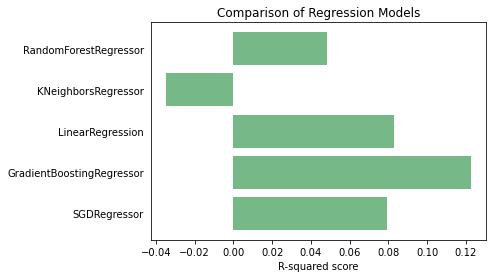

In [102]:
# R2 score results
fig, ax = plt.subplots()
ind = range(len(results))
ax.barh(ind, list(results.values()), align='center', 
        color = '#55a868', alpha=0.8)
ax.set_yticks(ind)
ax.set_yticklabels(results.keys())
ax.set_xlabel('R-squared score')
ax.tick_params(left=False, top=False, right=False) 
ax.set_title('Comparison of Regression Models')
fig.savefig('images/compare_models.png', bbox_inches = 'tight')

In [ ]:
The GradientBoostingRegressor has the best R2 score of ~13% so we focus on refining this particular model.

In [ ]:
# GradientBoostingRegressor will be used as the In-Hospit6al mortality prediction model
reg_model = GradientBoostingRegressor(random_state=0)   
reg_model.fit(X_train, y_train)
y_valid_preds = reg_model.predict(X_valid)
r2_not_refined = r2_score(y_valid, y_valid_preds)
print("R2 score is: {:2f}".format(r2_not_refined))

## 7. Parameter Tuning

To refine the GradientBoostingRegressor model, GridSearchCV function from scikit-learnis used to test out various permutations of parameters such as n_estimators, max_depth, and loss.

What is GridSearchCV and in general how it works? TO DO

## Calculate Performance Metrics


In [103]:
def calc_accuracy(y_actual, y_pred, thresh):
    # this function calculates the accuracy with probability threshold at thresh
    return (sum((y_pred > thresh) & (y_actual == 1))+sum((y_pred < thresh) & (y_actual == 0))) /len(y_actual)

def calc_recall(y_actual, y_pred, thresh):
    # calculates the recall
    return sum((y_pred > thresh) & (y_actual == 1)) /sum(y_actual)

def calc_precision(y_actual, y_pred, thresh):
    # calculates the precision
    return sum((y_pred > thresh) & (y_actual == 1)) /sum(y_pred > thresh)

def calc_specificity(y_actual, y_pred, thresh):
    # calculates specificity
    return sum((y_pred < thresh) & (y_actual == 0)) /sum(y_actual ==0)

So why are precision and recall even needed? They’re mostly useful in situations where the true class labels are highly skewed. For example, in our case we have training data with most of the entries that belong to 0 class (not-dead-at-the hospital) which is a good thing, but for what concerns the performance metric we can get 95% accuracy by just predicting class 0 for every entry.

With skewed data, if you just guess one class or the other, you can get excellent accuracy but either precision or recall will be very poor.

It’s standard practice to set a threshold value of 0.5 and then a result value that’s less than 0.5 is a prediction of class 0, and a result value that’s greater than 0.5 is a prediction of class 1.

We can adjust the accuracy of a binary classification model by adjusting the value of the threshold. For example, in our case if we set the threshold to something like 0.9 then most result values will be less than 0.9 and so most predictions will be class 0 and we’ll get good accuracy. But again, either precision or recall will be poor.

In [101]:
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

fpr_train, tpr_train, thresholds_train = roc_curve(y_train, y_train_preds)
fpr_valid, tpr_valid, thresholds_valid = roc_curve(y_valid, y_valid_preds)


thresh = 0.9

auc_train = roc_auc_score(y_train, y_train_preds)
auc_valid = roc_auc_score(y_valid, y_valid_preds)

print('Train AUC:%.3f'%auc_train)
print('Valid AUC:%.3f'%auc_valid)

print('Train accuracy:%.3f'%calc_accuracy(y_train, y_train_preds, thresh))
print('Valid accuracy:%.3f'%calc_accuracy(y_valid, y_valid_preds, thresh))


print('Train recall:%.3f'%calc_recall(y_train, y_train_preds, thresh))
print('Valid recall:%.3f'%calc_recall(y_valid, y_valid_preds, thresh))

print('Train precision:%.3f'%calc_precision(y_train, y_train_preds, thresh))
print('Valid precision:%.3f'%calc_precision(y_valid, y_valid_preds, thresh))

print('Train specificity:%.3f'%calc_specificity(y_train, y_train_preds, thresh))
print('Valid specificity:%.3f'%calc_specificity(y_valid, y_valid_preds, thresh))

print('Train prevalence:%.3f'%calc_prevalence(y_train))
print('Valid prevalence:%.3f'%calc_prevalence(y_valid))


ValueError: Found input variables with inconsistent numbers of samples: [268205, 7882]

In [ ]:
Finally, if we run the data through the classifier, and set the threshold to 0.0, 0.10, 0.20, . . , 0.90, 1.0 then each value of the threshold will genrate a different number of TP, FP, TN, FN. For each of the 11 threshold values, if we make a graph with FP on the x-axis and TP on the y-axis, we’ll get 11 dots. If we connect the dots we get what’s called a ROC curve (receiver operating characteristic).

In [ ]:
plt.plot(fpr_train, tpr_train,'r-', label = 'Train AUC: %.2f'%auc_train)
plt.plot(fpr_valid, tpr_valid,'b-',label = 'Valid AUC: %.2f'%auc_valid)
plt.plot([0,1],[0,1],'-k')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()